# XGBoost tuning with Bayesian Optimization 

By: Traci

XGBoost was tuned using bayesian optimization. 

More details can be found in readme.

In [2]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import string
pd.set_option('display.max_columns', 100)
from bayes_opt import BayesianOptimization

print("Data:\n",os.listdir("data"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Data:
 ['aggregated_features.csv', 'periods_test.csv', 'periods_train.csv', 'test.csv', 'test_active.csv', 'train.csv', 'train_active.csv', 'X.npz']


## Save/load data

In [2]:
# ## Save and load for train-validation sets
# from scipy import sparse

# #sparse.save_npz("X_valid.npz", X_valid)
# X_valid = sparse.load_npz("X_valid.npz")
# #sparse.save_npz("X_train.npz", X_train)
# X_train = sparse.load_npz("X_train.npz")

# #y_train.to_pickle('y_train.pkl')
# y_train = pd.read_pickle('y_train.pkl')
# #y_valid.to_pickle('y_valid.pkl')    
# y_valid = pd.read_pickle('y_valid.pkl')

In [22]:
testing = pd.read_csv('data/test.csv', index_col = "item_id", parse_dates = ["activation_date"])#.sample(1000)
testdex = testing.index

In [3]:
## Save and load for train-test sets
from scipy import sparse

#sparse.save_npz("avito_ridge_final/targetenc_X.npz", X)
X = sparse.load_npz("avito_ridge_final/X.npz")
#sparse.save_npz("avito_ridge_final/targetenc_testing.npz", testing)
testing = sparse.load_npz("avito_ridge_final/testing.npz")

#y.to_pickle('avito_ridge_final/targetenc_y.pkl')    #to save the dataframe, df to 123.pkl
y = pd.read_pickle('avito_ridge_final/targetenc_y.pkl')

In [5]:
import pickle
# with open("avito_ridge_final/targetenc_tfvocab.txt", "wb") as fp:   #Pickling 
#     pickle.dump(tfvocab, fp)

with open("avito_ridge_final/tfvocab.txt", "rb") as fp:   # Unpickling
   tfvocab = pickle.load(fp)

In [6]:
# For validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)

In [7]:
xgtrain = xgb.DMatrix(data=X_train, label=y_train)

In [8]:
xgval = xgb.DMatrix(data=X_valid, label=y_valid)

In [9]:
watchlist = [(xgval, 'eval')]

In [19]:
xgtest = xgb.DMatrix(data=testing)

## Bayesian Optimization for XGBoost

In [9]:
%%time 

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                lambdaa ):
    params = dict()
    params['objective'] = 'reg:logistic'
    params['booster'] = "gbtree"
    params['eval_metric'] = 'rmse'
    params['n_jobs'] = -1
    params['eta'] = 0.3
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['alpha '] = alpha 
    params['lambda']= lambdaa
    params['verbose_eval'] = True    

    m_xgb = xgb.train(params, xgtrain,
                           num_boost_round=100000,
                           early_stopping_rounds=50,
                          evals=watchlist,
                          verbose_eval = False
                         )

    return -float(m_xgb.attr("best_score"))


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (7, 30),
                              'min_child_weight': (0, 200),
                              'colsample_bytree': (0.1, 0.7),
                              'subsample': (0.6, 1), #using a fraction of objects makes model generalize better, probably
                              'gamma': (0, 2),
                              'alpha': (0, 2),
                              'lambdaa': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=4, n_iter=25)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   lambdaa |   max_depth |   min_child_weight |   subsample | 
    1 | 12m00s |   -0.22018 |    0.1811 |             0.4163 |    1.0728 |    1.7154 |     27.5597 |            19.3760 |      0.8532 | 
    2 | 29m23s |   -0.21856 |    1.7412 |             0.5046 |    1.5346 |    0.6557 |     10.2929 |           103.7318 |      0.8659 | 
    3 | 08m52s |   -0.22366 |    1.5826 |             0.2635 |    1.3957 |    0.0729 |     21.5664 |             1.2775 |      0.9062 | 
    4 | 18m40s |   -0.21887 |    1.0174 |             0.5325 |    0.5713 |    0.8236 |     18.1567 |           199.1020 |      0.6967 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------------------
 Step 

KeyboardInterrupt: 

In [10]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambdaa,max_depth,min_child_weight,subsample,score
2,0.257868,0.350452,1.984805,1.989459,8.489096,187.412416,0.907907,-0.218484
10,1.997815,0.667456,0.002864,1.362883,8.055473,156.833013,0.917944,-0.218608
7,0.200968,0.690297,1.975469,1.954729,19.568207,105.122028,0.785710,-0.218698
6,0.062207,0.670226,1.901103,0.088602,28.159023,173.786800,0.726805,-0.218760
4,1.767074,0.374175,1.670748,1.903646,28.583216,198.775070,0.767384,-0.218796


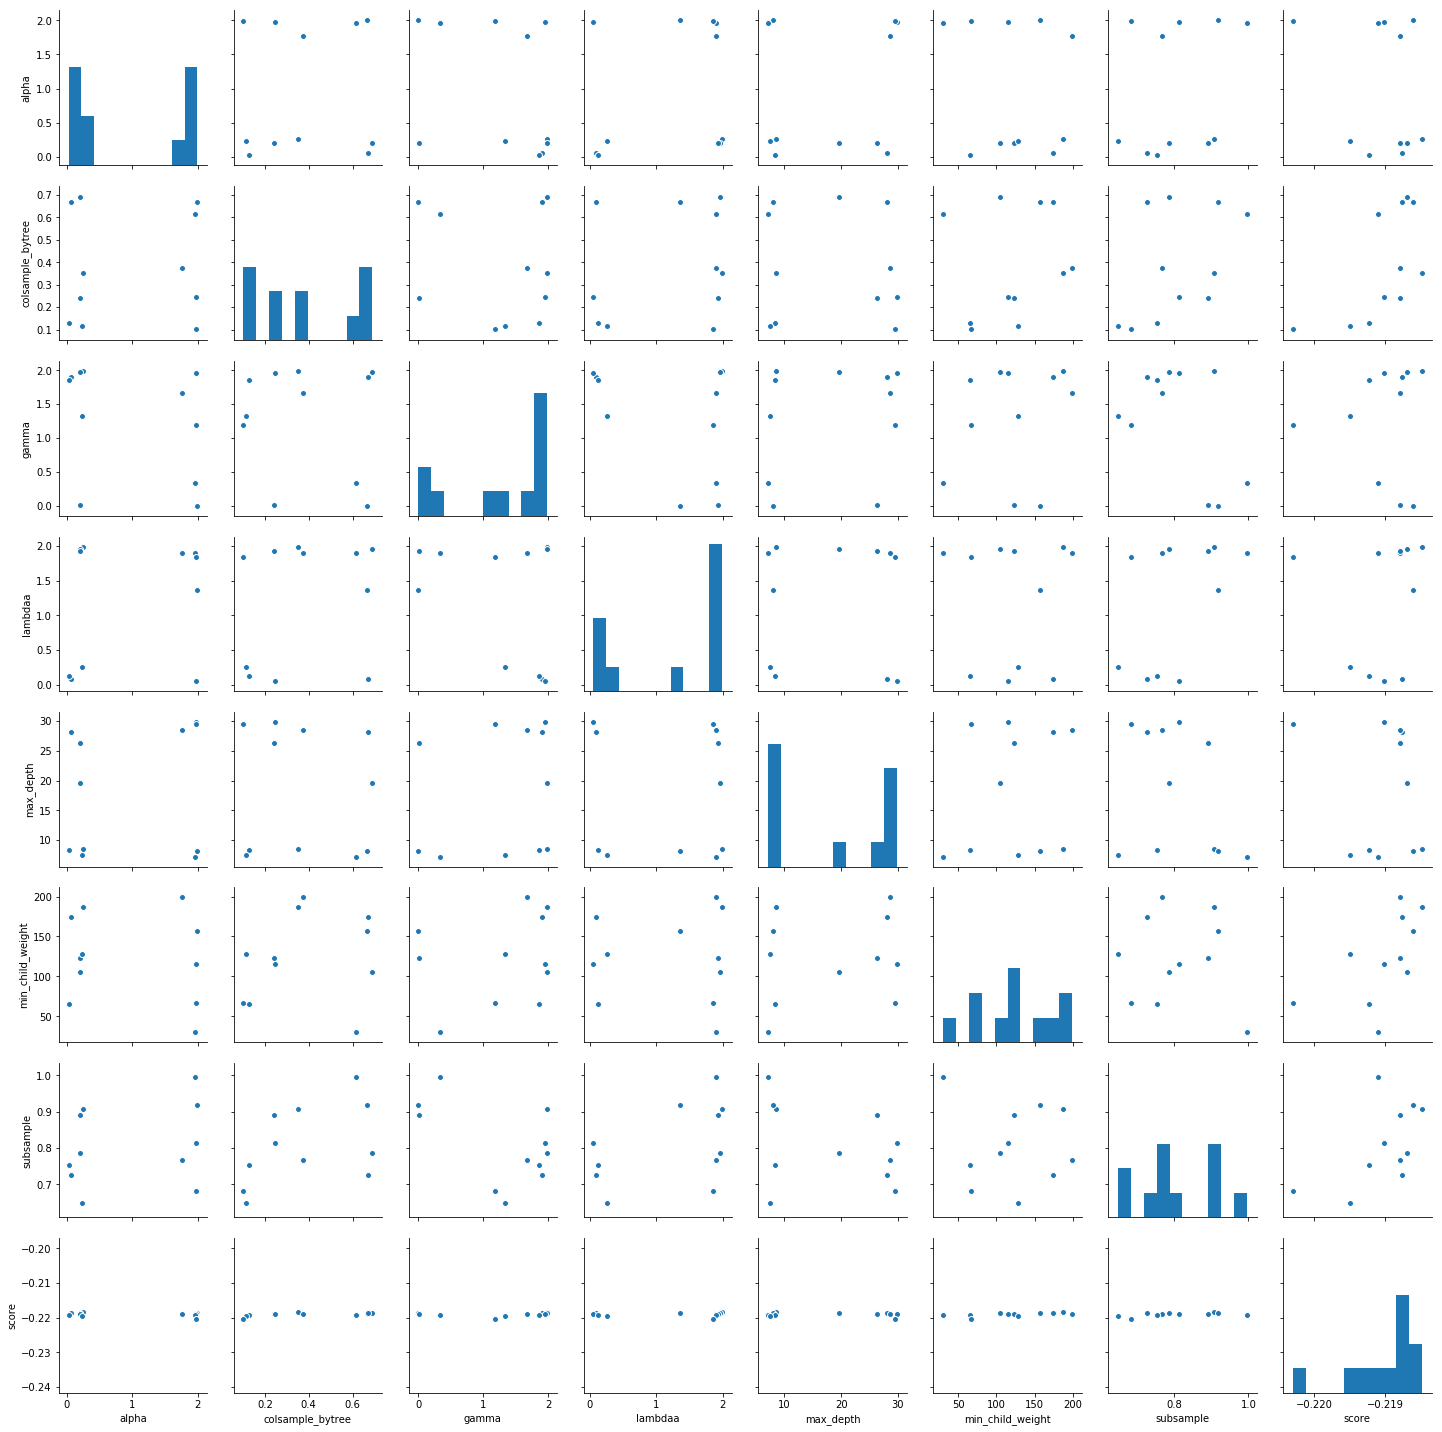

In [11]:
import seaborn as sns
%matplotlib inline
sns.pairplot(xgb_BO_scores)
#plt.show()

In [12]:
xgb_params = xgb_BO_scores.iloc[0].to_dict()
xgb_params

{'alpha': 0.2578675178084593,
 'colsample_bytree': 0.3504522847639341,
 'gamma': 1.984805124969772,
 'lambdaa': 1.9894590303715745,
 'max_depth': 8.489096430232564,
 'min_child_weight': 187.4124157610732,
 'subsample': 0.90790655644221,
 'score': -0.218484}

In [ ]:
%%time

xgb_params = xgb_BO_scores.iloc[0].to_dict()
xgb_params['objective'] = 'reg:logistic'
xgb_params['booster'] = "gbtree"
xgb_params['eval_metric'] = 'rmse'
xgb_params['n_jobs'] = -1
xgb_params['eta'] = 0.03 # Smaller 

xgb_params['max_depth'] = int(xgb_params['max_depth'])   
xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])    
xgb_params['subsample'] = xgb_params['subsample']     
xgb_params['colsample_bytree'] = xgb_params['colsample_bytree']
xgb_params['gamma'] = xgb_params['gamma']
xgb_params['alpha '] = xgb_params['alpha']
xgb_params['lambda']= xgb_params['lambdaa']
#xgb_params['seed']=1234

In [12]:
xgb_params = dict()

xgb_params['objective'] = 'reg:logistic'
xgb_params['booster'] = "gbtree"
xgb_params['eval_metric'] = 'rmse'
xgb_params['n_jobs'] = -1
xgb_params['eta'] = 0.02 # Smaller 

xgb_params['max_depth'] = 18
xgb_params['min_child_weight'] = 8  
xgb_params['subsample'] = 0.8   
xgb_params['colsample_bytree'] = 0.7
xgb_params['gamma'] = 0
xgb_params['alpha '] = 0
xgb_params['lambda']= 0.2

In [13]:
xgb_params

{'objective': 'reg:logistic',
 'booster': 'gbtree',
 'eval_metric': 'rmse',
 'n_jobs': -1,
 'eta': 0.02,
 'max_depth': 18,
 'min_child_weight': 8,
 'subsample': 0.8,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'alpha ': 0,
 'lambda': 0.2}

In [14]:
m_xgb = xgb.train(xgb_params, xgtrain,
                           num_boost_round=100000,
                           early_stopping_rounds=50,
                          evals=watchlist,
                          verbose_eval = 100
                         )

best_xgb_score = float(m_xgb.attr("best_score"))
best_xgb_iteration = float(m_xgb.attr("best_iteration"))

[0]	eval-rmse:0.438052
Will train until eval-rmse hasn't improved in 50 rounds.
[100]	eval-rmse:0.228901
[200]	eval-rmse:0.221563
[300]	eval-rmse:0.22088
[400]	eval-rmse:0.220585
[500]	eval-rmse:0.22047
[600]	eval-rmse:0.22038
[700]	eval-rmse:0.220316
[800]	eval-rmse:0.220279
[900]	eval-rmse:0.220248
[1000]	eval-rmse:0.220233
[1100]	eval-rmse:0.220199
[1200]	eval-rmse:0.220175
[1300]	eval-rmse:0.220125
[1400]	eval-rmse:0.220094
[1500]	eval-rmse:0.220067
[1600]	eval-rmse:0.22004
[1700]	eval-rmse:0.220021
[1800]	eval-rmse:0.220003
[1900]	eval-rmse:0.219975
[2000]	eval-rmse:0.219967
[2100]	eval-rmse:0.219944
[2200]	eval-rmse:0.219936
Stopping. Best iteration:
[2175]	eval-rmse:0.219936



In [17]:
m_xgb

In [17]:
from sklearn.externals import joblib
# save model
joblib.dump(m_xgb, 'm_xgb.pkl')
# load model
#gbm_pickle = joblib.load('lgb.pkl')

['m_xgb.pkl']

In [15]:
xgb_f = xgb.DMatrix(data=X, label=y)

In [16]:
m_xgb = xgb.train(xgb_params, xgb_f,
                           num_boost_round=2175,
                           verbose_eval = 50
                          )

In [20]:
xgb_pred = m_xgb.predict(xgtest)

In [23]:
xgb_submission = pd.DataFrame(xgb_pred,columns=["deal_probability"],index=testdex)
xgb_submission['deal_probability'].clip(0.0, 1.0, inplace=True)
xgb_submission.to_csv("final_ridge_aggfeats_xgb-21994-.csv",index=True,header=True) # Between 0 and 1